In [5]:
from read_ggp_run import *
from cells_simulation import *
import scipy.stats

In [6]:
def cell_cycle_time(cell):
    new_cell = copy.deepcopy(cell)
    resc = cell.time[-1] - cell.time[0] 
    new_cell.time = (np.array(cell.time) - cell.time[0])/ resc
    return new_cell

def calc_dev(cell_p, cell_true):
    new_cell = copy.deepcopy(cell_p)

    new_cell.log_length = np.array(cell_p.log_length) - np.array(cell_true.log_length)
    new_cell.gfp = np.array(cell_p.gfp) - np.array(cell_true.gfp)
    return new_cell

def plot_binned_stats(ax, time, dev, title, color, bins=10):
    bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(time, dev,  statistic='mean', bins=bins)
    bin_std, _, _ = scipy.stats.binned_statistic(time, dev,  statistic='std', bins=bins)
    bin_centers = bin_edges[1:] - (bin_edges[1] - bin_edges[0])/2

    ax.axhline(0, ls='--', color="black", alpha=0.5)
    ax.plot(time, dev, '.', color="grey", alpha=0.05)

    ax.plot(bin_centers, bin_means, color=color, label=title+" (binned mean with std)")
    ax.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color=color, alpha=0.2)
    ax.set_ylabel("deviation (prediction-true)")
    ax.set_xlabel("time/cell cycle")
    ax.legend()

def binned_dev(cells_prediction, cells_true, bins=10):
    time = []
    log_length_dev = []
    gfp_dev = [] 

    for i, c in enumerate(cells_true):
        time += list(cell_cycle_time(cells_prediction[i]).time)
        log_length_dev  += list(np.array(cells_prediction[i].log_length) - np.array(cells_true[i].log_length))
        gfp_dev         += list(np.array(cells_prediction[i].gfp) - np.array(cells_true[i].gfp))

    _, ax = plt.subplots(1,2, figsize=(20,5))

    plot_binned_stats(ax[0], time, log_length_dev, "log length", "tab:blue", bins=bins)
    plot_binned_stats(ax[1], time, gfp_dev, "gfp", "tab:orange", bins=bins)

    plt.show()


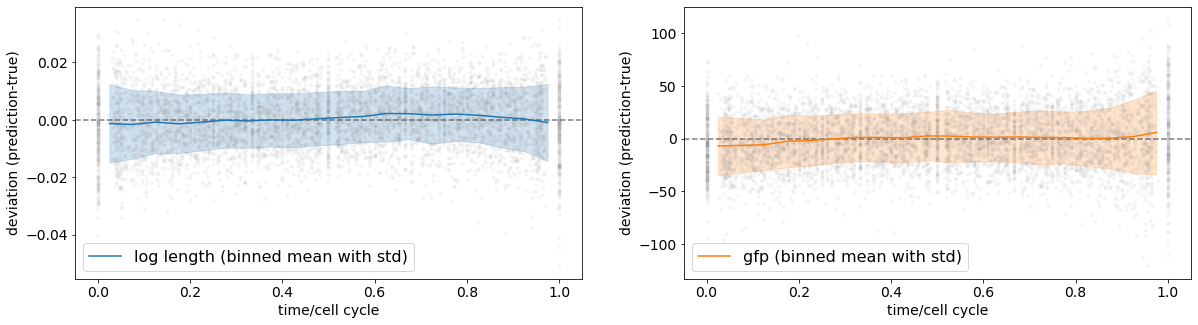

In [7]:
for i in range(1):

    directory = '../data/simulation_set/simulation_set_{:d}'.format(i)
    sample = 'simulation_set_{:d}'.format(i)

    filebase = default_filebase(directory, sample) # default

    dat_file = get_data_file(directory, sample)
    prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

    indata = pd.read_csv(dat_file)
    prediction = pd.read_csv(prediction_file, skiprows=13)

    cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
    cells_noise = df2cells(prediction, time="time", log_length="log_length", gfp="fp", parent_id=None)
    cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
    binned_dev(cells_prediction, cells_true, bins=20)


In [8]:
def var_predictions(cells_prediction, cells_true, bins=10):
    log_length_dev = []
    gfp_dev = [] 
    for i, c in enumerate(cells_true):
        log_length_dev  += list(np.array(cells_prediction[i].log_length) - np.array(cells_true[i].log_length))
        gfp_dev         += list(np.array(cells_prediction[i].gfp) - np.array(cells_true[i].gfp))
    var_log_length_dev = np.var(log_length_dev)
    var_gfp_dev = np.var(gfp_dev)
    return var_log_length_dev, var_gfp_dev

In [9]:
def plot_var_predictions(directory_templ, sample_templ, no=5, x="var_x", xlabel="x"):
    fig, ax = plt.subplots() 
    ax.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    ax2 = ax.twinx()
    ax2.ticklabel_format(style='sci', scilimits=(-1,2), useOffset=False)

    init = []
    final = []
    final_second = []
    var1 = []
    var2 = []
    gfp_t = []
    ll_t = []
    for i in range(no):
        directory = directory_templ.format(i)
        sample = sample_templ.format(i)
        filebase = default_filebase(directory, sample) # default

        dat_file = get_data_file(directory, sample)
        prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)

        indata = pd.read_csv(dat_file)
        prediction = pd.read_csv(prediction_file, skiprows=13)

        params_config = read_params_config(prediction_file)
        init.append(get_params_config(params_config, x)["init"].values[0])
        final.append(get_params_config(params_config, x)["final"].values[0])

        if x == "var_g":
            final_second.append(get_params_config(params_config, "var_x")["final"].values[0])
        else:
            final_second.append(get_params_config(params_config, "var_g")["final"].values[0])

        cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", parent_id=None)
        for cell in cells_true:
            gfp_t += cell.gfp
            ll_t += cell.log_length
        cells_prediction = df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", parent_id=None)
        var_log_length_dev, var_gfp_dev = var_predictions(cells_prediction, cells_true)

        var1.append(var_log_length_dev)
        var2.append(var_gfp_dev)

    c1 = "darkred"
    c2 = "tab:blue"

    sq_init = np.sqrt(np.array(init))
    sq_final = np.sqrt(np.array(final))
    sq_final_second = np.sqrt(np.array(final_second))
    sq_var1 = np.sqrt(np.array(var1))
    sq_var2 = np.sqrt(np.array(var2))


    if x == "var_g":
        ax.scatter(sq_init, sq_var2, color=c1, 
                    label=r"std gfp (prediction - true) | $\langle g(t) \rangle_t =${:.0f}".format(np.mean(gfp_t)))
        

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c1, ls="--")
        ax2.scatter(sq_init, sq_var1, color=c2, 
                    label=r"std log length (prediction - true)| $\langle x(t) \rangle_t =${:.3f}".format(np.mean(ll_t)))

        ax.tick_params(axis='y', colors=c1)
        ax2.tick_params(axis='y', colors=c2)

        ax2.set_ylabel(r"log length")
        ax.set_ylabel(r"gfp")

        ax.yaxis.label.set_color(c1)
        ax2.yaxis.label.set_color(c2)

        ax.set_ylim([0,np.max(sq_var2)*1.1])
        ax2.set_ylim([0,np.max(sq_var1)*1.1])

    else:
        ax.scatter(sq_init, sq_var1, color=c2, 
                    label=r"std log length (prediction - true)| $\langle x(t) \rangle_t =${:.3f}".format(np.mean(ll_t)))

        # ax.scatter(init, final, color='grey', label="inferred")
        ax.plot(np.linspace(0,sq_init[-1],10), 
                np.linspace(0,sq_init[-1],10), color=c2, ls="--")
        ax2.scatter(sq_init, sq_var2, color=c1, 
                    label=r"std gfp (prediction - true) | $\langle g(t) \rangle_t =${:.0f}".format(np.mean(gfp_t)))
        
        ax.tick_params(axis='y', colors=c2)
        ax2.tick_params(axis='y', colors=c1)

        ax.set_ylabel(r"log length")
        ax2.set_ylabel(r"gfp")

        ax.yaxis.label.set_color(c2)
        ax2.yaxis.label.set_color(c1)

        ax.set_ylim([0,np.max(sq_var1)*1.1])
        ax2.set_ylim([0,np.max(sq_var2)*1.1])
    ax.set_xlabel(xlabel)

    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
    plt.show()

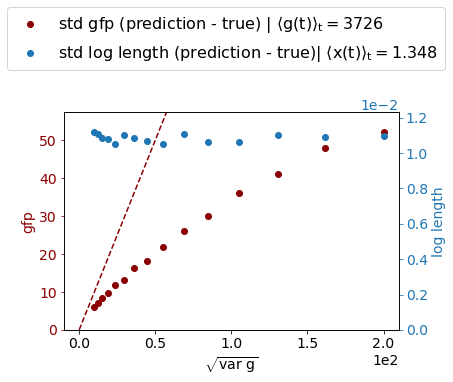

In [10]:
plot_var_predictions('../data/n250_var_g_adder/n250_var_g_adder_{:d}', 'n250_var_g_adder_{:d}', no=15, x="var_g", xlabel=r"$\sqrt{var\ g}$" )

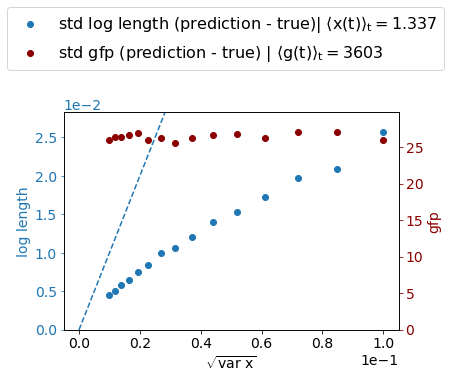

In [11]:
plot_var_predictions('../data/n250_var_x_adder/n250_var_x_adder_{:d}', 'n250_var_x_adder_{:d}', no=15, x="var_x", xlabel=r"$\sqrt{var\ x}$" )